# Clustering
We utilized clustering to create user and item clusters as a way to further experiment with classical recommendation systems like ALS, SVD++ and NMF. Through clustering we improved computational efficiency by minimizing our search space. Clustering was done through the use of uniform manifold approximation and projection, or UMAP, and scikit-learn.  Similarly for users, we calculated feature scores and average time of day of interaction and performed the same procedures. 

## Clustering News
For news clustering, we first vectorized the titles and abstracts with scikit-learns TF-IDF and BOW vectorizers. Afterwards, we performed dimension reduction to two components with UMAP under both hellinger and euclidean distance metrics, then performed clustering of the results with HDBSCAN and Kmeans.

In [5]:
import clustering_modules as cm
import pandas as pd
# Loading in the data for tf-idf and bag of words vectorization methods.
news_text = pd.read_csv('../MIND_large/csv/news.csv', index_col=0).set_index('news_id').drop(columns=['url','title_entities','abstract_entities'])
news_text.head()

,category,sub_category,title,abstract
news_id,,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
N86255,health,medical,Dispose of unwanted prescription drugs during ...,NaN
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."


In [6]:
# Create our UMAP_embeddings for our vectorization types and distance metrics.
bow_matrix, tf_matrix = cm.vectorize_items(news_text)
bow_embeddings = [cm.create_UMAP_embeddings(2, bow_matrix, 'euclidean'), cm.create_UMAP_embeddings(2, bow_matrix)]
tf_embeddings = [cm.create_UMAP_embeddings(2, tf_matrix, 'euclidean'), cm.create_UMAP_embeddings(2, tf_matrix)]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 257 edges.
It has only fully disconnected 3 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:190: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  return super().__call__(*args, **kws)
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 191 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [15]:
# Apply kmeans and hdbscan clustering algorithms to our embeddings
from sklearn.impute import SimpleImputer
embeddings = bow_embeddings + tf_embeddings
kmeans_labels = [cm.create_kmeans_labels(SimpleImputer(strategy='mean').fit_transform(embeddings[index]), n_clusters=30) for index in [0, 2, 1, 3]]
hdbscan_labels = [cm.create_hdbscan_labels(embeddings[index]) for index in [0, 2, 1, 3]]

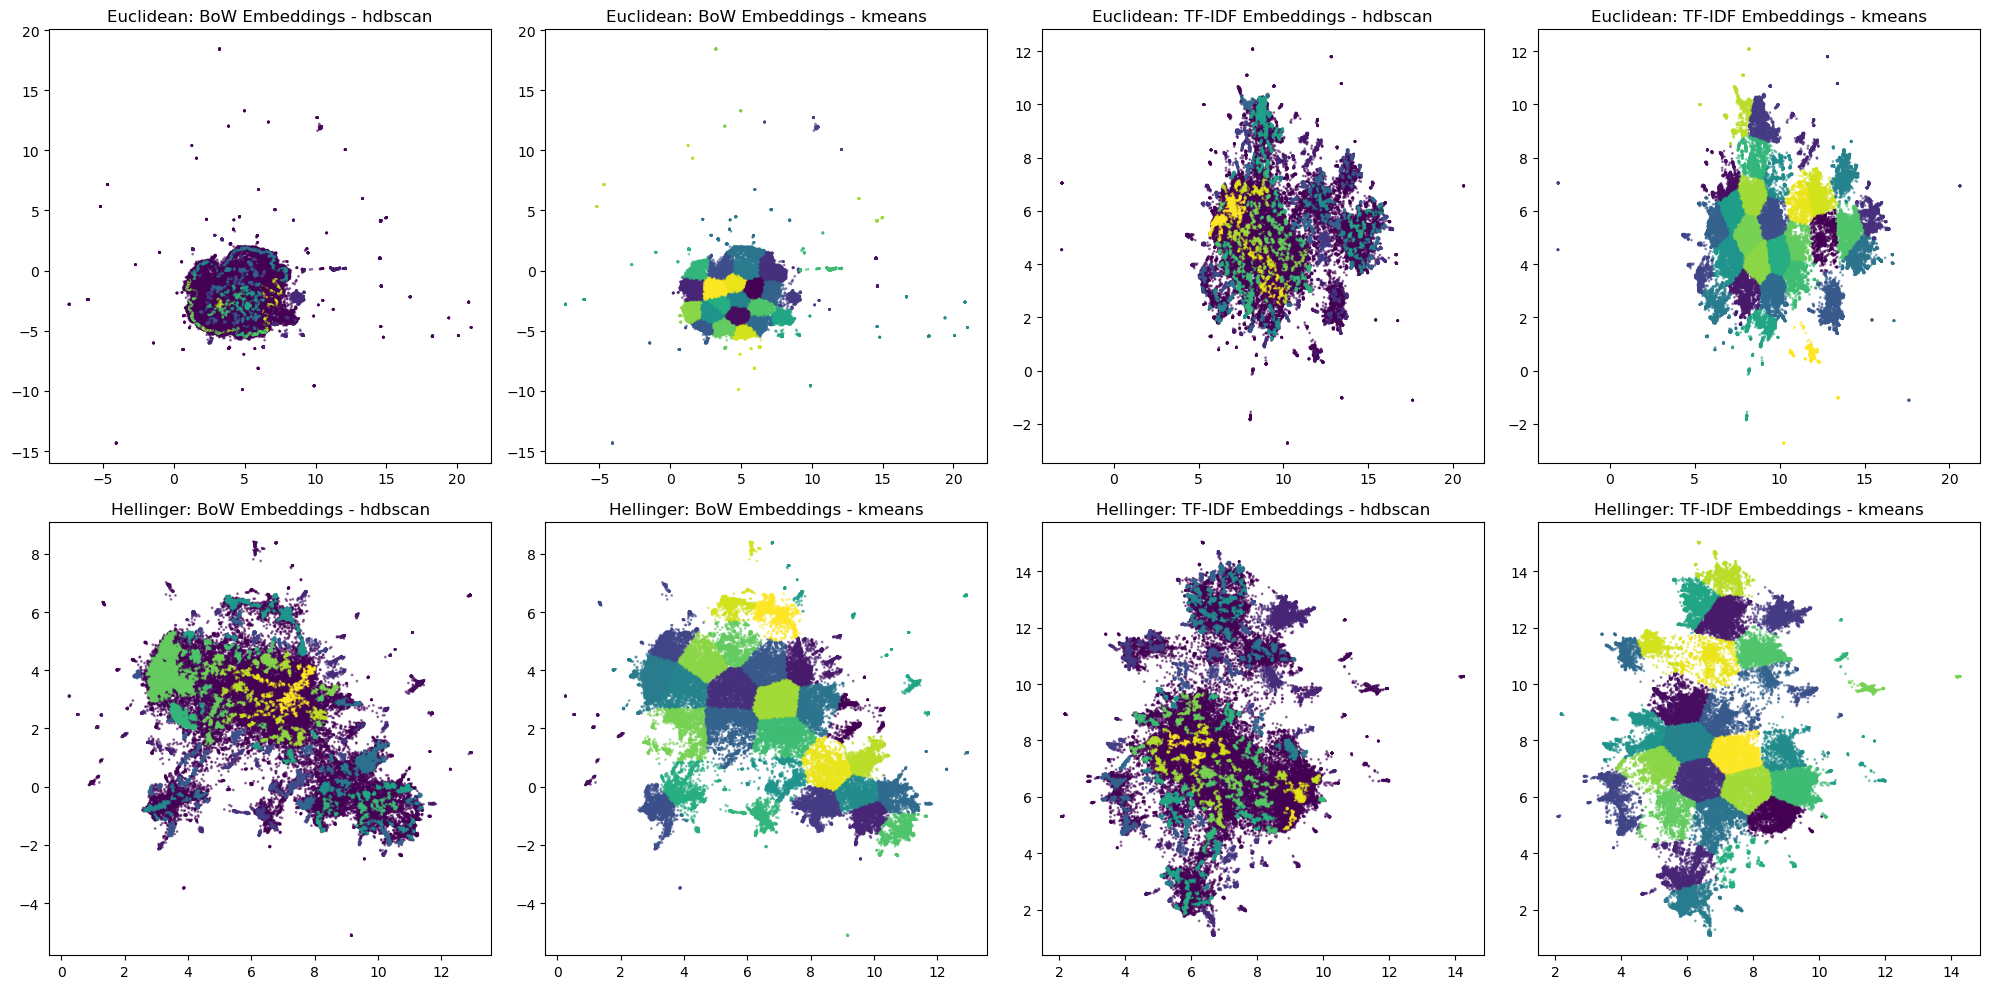

In [16]:
# Plot clustering results
cm.visualize_all_item_clusters(bow_embeddings, tf_embeddings, ['Euclidean', 'Hellinger'], hdbscan_labels, kmeans_labels, cmap='viridis')

### Findings
As visible above, hdbscan classified a lot of items as noise. Since our goal was to simply minimize the search space we avoided using clusters created by hdbscan and instead focused on using clusters created from kmeans. We can see that under the hellinger distance metric there are less outliers and while clusters created for bag of words are more tightly packed together, tf-idf had larger cluster size. Ultimately we chose to apply clusters created by kmeans on tf-idf embeddings under the hellinger distance metric. Going beyond how clusters appear visually, below we examine a couple titles belonging to cluster 2. Notably, titles all relate to each other and seem to be referring to sports. Pleased with the results we moved on to clustering users.

In [27]:
cluster_labels = kmeans_labels[3] # The third index refers to kmeans clustering labels for the TF-IDF embeddings reduced with the hellinger metric.
news_text['labels'] = cluster_labels
news_text[news_text['labels'] == 2]['title'].head().to_list()

['Colts News: Chris Ballard on first half of season, rookie development, trade deadline',
 'All eyes on Drew Brees as possibility of return nears',
 'Opponent QB Stat Tracker: Mason Rudolph',
 'Rams Week 8 snap count analysis',
 'Titans force 4 turnovers by Winston, hold off Buccaneers']

In [28]:
news_text.to_csv('../MIND_large/csv/news_cluster_labels.csv')

## Clustering Users
For user clustering we calculated and normalized their preferences for specific categories and found the median time of day they interact. Similarly to news, we performed dimension reduction to two components with UMAP under a euclidean distance metric, then performed clustering of the results with HDBSCAN and Kmeans.

In [2]:
import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import data_processing_modules as dpm
import umap.umap_ as umap

2024-03-01 08:36:02.781287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 08:36:02.781368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 08:36:02.783136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def create_big_boy():
    full = pd.DataFrame()
    for i in range(4):
        df = pd.read_csv(f"../MIND_large/csv/tensorflow_dataset_chunk{i}.csv", index_col=0)
        full = pd.concat([full, df])
    return full
full_tf = create_big_boy()

In [5]:
def apply_transformations(df):
    user = dpm.create_user_taste_profile(df)
    
    # Obtain the median hour of interaction for users and append it to the user feature matrix.
    dates = dpm.create_times(df)
    dates_frame = dates.to_frame().reset_index()
    dates_frame["median"] = dates.apply(dpm.median_hour).values
    user["median"] = dates_frame["median"]

    # Scale the category preferences.
    user = dpm.scaling_data(user)

    # Scale the median interaction time.
    user["median"] = user["median"] / 24
    return user

embedding_ready = apply_transformations(full_tf)

In [6]:
embedding_ready.head()

,user_id,news,entertainment,finance,video,tv,movies,music,autos,health,foodanddrink,lifestyle,sports,travel,weather,middleeast,kids,games,median
0,U1,0.444444,0.236111,0.111111,0.083333,0.097222,0.013889,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
1,U100,0.162791,0.046512,0.046512,0.046512,0.023256,0.000000,0.046512,0.069767,0.116279,0.116279,0.209302,0.116279,0.000000,0.000000,0.0,0.0,0.0,0.208333
2,U1000,0.444444,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.111111,0.222222,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
3,U10000,0.091954,0.022989,0.137931,0.034483,0.045977,0.022989,0.022989,0.011494,0.114943,0.264368,0.149425,0.057471,0.022989,0.000000,0.0,0.0,0.0,0.500000
4,U100005,0.354839,0.000000,0.043011,0.010753,0.032258,0.043011,0.000000,0.000000,0.021505,0.225806,0.086022,0.150538,0.000000,0.032258,0.0,0.0,0.0,0.583333


In [19]:
embedding_ready.to_csv('../MIND_large/csv/user_features.csv')

In [7]:
embedding_ready.iloc[:, 1:]

,news,entertainment,finance,video,tv,movies,music,autos,health,foodanddrink,lifestyle,sports,travel,weather,middleeast,kids,games,median
0,0.444444,0.236111,0.111111,0.083333,0.097222,0.013889,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
1,0.162791,0.046512,0.046512,0.046512,0.023256,0.000000,0.046512,0.069767,0.116279,0.116279,0.209302,0.116279,0.000000,0.000000,0.0,0.0,0.0,0.208333
2,0.444444,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.111111,0.222222,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.333333
3,0.091954,0.022989,0.137931,0.034483,0.045977,0.022989,0.022989,0.011494,0.114943,0.264368,0.149425,0.057471,0.022989,0.000000,0.0,0.0,0.0,0.500000
4,0.354839,0.000000,0.043011,0.010753,0.032258,0.043011,0.000000,0.000000,0.021505,0.225806,0.086022,0.150538,0.000000,0.032258,0.0,0.0,0.0,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.416667
248969,0.400000,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.000000,0.066667,0.066667,0.133333,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.291667
248970,0.192308,0.000000,0.076923,0.000000,0.000000,0.076923,0.038462,0.000000,0.038462,0.115385,0.269231,0.153846,0.038462,0.000000,0.0,0.0,0.0,0.375000
248971,0.333333,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.291667


In [8]:
user_embeddings = umap.UMAP(n_neighbors = 80, min_dist=0.0, n_components=2, random_state=42, n_jobs=1).fit_transform(embedding_ready.iloc[:, 1:])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
kmeans_labels = cluster.KMeans(n_clusters=40).fit_predict(user_embeddings)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
import matplotlib.pyplot as plt

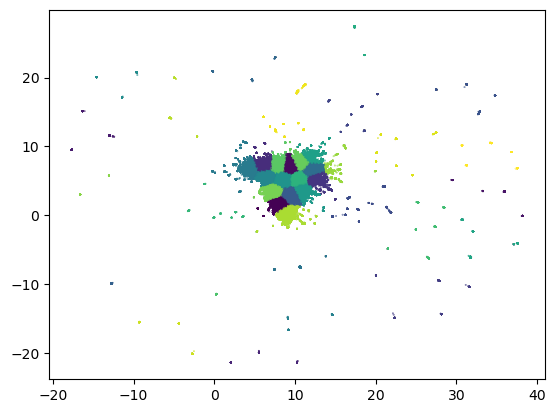

In [11]:
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], c=kmeans_labels, s=0.1, cmap='viridis');

,news_id,category,sub_category,title,abstract,labels
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",1
1,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,13
2,N86255,health,medical,Dispose of unwanted prescription drugs during ...,.,25
3,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,12
4,N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",29


In [42]:
all_ratings2.reset_index()

,index,user_id,news_id,scores
0,0,U1,"[N14639, N27258, N63237, N112729, N42180, N109...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,U100,"[N99587, N61339, N129790, N12721, N100405, N10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,U1000,"[N33446, N20131, N65823, N65823, N111503, N399...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,3,U10000,"[N34918, N81659, N128643, N97343, N103301, N92...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,U100005,"[N53796, N41484, N95178, N27038, N72493, N3850...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
255985,255985,U99984,"[N121592, N127001, N53018, N129416, N2110, N18...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
255986,255986,U99989,"[N91, N108143, N26493, N15986, N82348, N71068,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
255987,255987,U99993,"[N67397, N67770, N41129, N128503, N51724, N721...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
255988,255988,U99994,"[N94577, N30729, N127177, N14611, N82747, N544...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [23]:
all_ratings.reset_index().head()

,user_id,news_id
0,U1,"[N14639, N27258, N63237, N112729, N42180, N109..."
1,U100,"[N99587, N61339, N129790, N12721, N100405, N10..."
2,U1000,"[N33446, N20131, N65823, N65823, N111503, N399..."
3,U10000,"[N34918, N81659, N128643, N97343, N103301, N92..."
4,U100005,"[N53796, N41484, N95178, N27038, N72493, N3850..."


In [3]:
def create_big_boy():
    full = pd.DataFrame()
    for i in range(4):
        df = pd.read_csv(f"../MIND_large/csv/tensorflow_dataset_chunk{i}.csv", index_col=0)
        full = pd.concat([full, df])
    return full
full_tf = create_big_boy()
news_text = pd.read_csv('../MIND_large/csv/news_cluster_labels.csv')
news_text.head()
news_text.dtypes
news_text['labels'].unique()
full_tf[full_tf['score'] == 1] # subsetting for only positive interactions, under the assumption of an implicit feedback system
all_ratings = full_tf[full_tf['score'] == 1].groupby('user_id')['news_id'].apply(list)
all_ratings2 = full_tf.groupby('user_id')['news_id'].apply(list).reset_index()
scores = full_tf.groupby('user_id')['score'].apply(list).reset_index()
all_ratings2['scores'] = scores['score']

In [5]:
all_ratings2.head()

,user_id,news_id,scores
0,U1,"[N14639, N27258, N63237, N112729, N42180, N109...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,U100,"[N99587, N61339, N129790, N12721, N100405, N10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,U1000,"[N33446, N20131, N65823, N65823, N111503, N399...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,U10000,"[N34918, N81659, N128643, N97343, N103301, N92...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,U100005,"[N53796, N41484, N95178, N27038, N72493, N3850...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [9]:
d = {"A" : 1}
list(d.values())

[1]

Note for later: go over indexing and make sure everything is lining up properly 

In [15]:
item_clusters = {item : cluster for item, cluster in zip(news_text['news_id'], news_text['labels'])}

def create_item_cluster_mat(rating_mat, num_users = 255990):
    """
    Creates a matrix utilizing item clusters to improve calculation efficiency.
    """
    # for the hash tables we want to have one that builds the matrix, cluster : scores []
    # and one that can be used to check which cluster something belongs to
    # rename rating mat
    matrix = {cluster : np.full(num_users, 0, dtype='int8') for cluster in range(30)} 
    counter = 0
    for user, ratings, score in zip(rating_mat['user_id'], rating_mat['news_id'], rating_mat['scores']):
        for index in range(len(ratings)):
            news_id = ratings[index]
            num = score[index]
            if num != 0:    
                matrix[item_clusters[news_id]][counter] += 1
        counter += 1
    return np.column_stack(list(matrix.values()))
matrix = create_item_cluster_mat(all_ratings2)
np.save('../MIND_large/csv/item_cluster_mat.npy', matrix)

In [12]:
user_clustered = pd.read_csv('../MIND_large/csv/full_user_clusters.csv')

In [13]:
user_clustered['cluster'].unique()

array([6, 2, 1, 3, 7, 9, 4, 0, 8, 5])

In [16]:

user_clusters= {user : cluster for user, cluster in zip(user_clustered['user_id'], user_clustered['cluster'])}
def create_user_cluster_mat(rating_mat, num_user_clusters=10):
    """
    Creates a matrix utilizing user clusters to improve calculation efficiency.
    """
    matrix = {news_id : np.full(num_user_clusters, 0, dtype='int8') for news_id in news_text['news_id']}
    # will have clusters as rows, so need to determine length of clusters applied to the dataset 
    for user, ratings, score in zip(rating_mat['user_id'], rating_mat['news_id'], rating_mat['scores']):
        cluster = user_clustered[user]
        for index in range(len(ratings)):
            news_id = ratings[index]
            num = score[index]
        if num != 0:    
            matrix[item_clusters[news_id]][cluster] += 1
        
    return np.column_stack(list(matrix.values()))   
    
matrix = create_item_cluster_mat(all_ratings2)
np.save('../MIND_large/csv/user_cluster_mat.npy', matrix)

In [ ]:
def subset_clusters(user_cluster, item_cluster):
    """
    when given user and item clusters, subsets the matrix for users and items in the cluster 
    """
    # Subset df for either cluster and thats it? might have to do some similarity or distance metric, or get the
    # highest rated news cluster from the other matrix for all users (post normalization? probably not?)
    # so starting with user clusters then, we would get the group of users, find the highest rated news cluster amongst them
    # and then we would have the space minimized to that group of users and thier news cluster with the most ratings, 
    # what if there is the same number of ratings for a different news cluster? then we would have to evaluate the next steps off of
    # a secondary conditional 
    